<a href="https://colab.research.google.com/github/naoya1110/DL_Lecture_202107/blob/main/Chapter08_UdonAI_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 08: UdonAI Baseline
準備したうどんのデータセットを使ってうどんAIを作ってみましょう。

## 準備

### パッケージのインポート

In [1]:
import os
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.set_printoptions(precision=3,  suppress=True)
import seaborn as sns
import cv2
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, InputLayer
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.math import confusion_matrix

# TensorFlowのバージョンを確認
print("TensorFlow version: " + tf.__version__)

TensorFlow version: 2.5.0


### うどん店名のリストを作成
うどん店名をリストアップします。順番はChapter07の`udonya_index`と同じです。

In [2]:
udonya_list = ["nagata-in-kanoka", "udon-bakaichidai", "yamagoe", "gamou", "hinode-seimenjo",
                      "ippuku", "moriya", "yoshiya", "sakaeda", "yamadaya"]

udonya_list

['nagata-in-kanoka',
 'udon-bakaichidai',
 'yamagoe',
 'gamou',
 'hinode-seimenjo',
 'ippuku',
 'moriya',
 'yoshiya',
 'sakaeda',
 'yamadaya']

## データの準備

### Googleドライブのマウント
Googleドライブをマウントし，ファイルにアクセスできるようにしてください。

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


googleドライブ内の`DL_Lecture_202107`ディレクトリを作業ディレクトリ`working_dir`として設定します。

In [4]:
working_dir = "/content/drive/MyDrive/DL_Lecture_202107"

### データの読み込み
Chapter07で作成したデータセット`udon10_dataset.npz`を読み込みます。

In [5]:
dataset_name = "udon10_dataset.npz"
dataset_path = os.path.join(working_dir, dataset_name)

data = np.load(dataset_path) 

trainX = data["trainX"].astype("float32")
trainY = data["trainY"]
validX = data["validX"].astype("float32")
validY = data["validY"]
testX = data["testX"].astype("float32")

### 読み込んだデータのshapeを確認
読み込んだデータが間違っていないかshapeを確認しましょう。

In [6]:
print("Data Shape")
print("trainX:", trainX.shape)
print("trainY:", trainY.shape)
print("validX:", validX.shape)
print("validY:", validY.shape)
print("testX:", testX.shape)

Data Shape
trainX: (10000, 128, 128, 3)
trainY: (10000,)
validX: (500, 128, 128, 3)
validY: (500,)
testX: (500, 128, 128, 3)


### trainY, validYをonehotベクトル形式に変換
MNISTのときと同様に出力データをonehotベクトルに変換します。

In [7]:
trainY_onehot = to_categorical(trainY)
validY_onehot = to_categorical(validY)

### 学習に使用するデータのshapeを確認
今回使用するデータはtrainX, trainY_onehot, validX, validY_onehot, testXです。shapeを確認しておきましょう。

In [8]:
print("Data shapes")
print("trainX:", trainX.shape)
print("trainY_onehot:", trainY_onehot.shape)
print("validX:", validX.shape)
print("validY_onehot:", validY_onehot.shape)
print("testX:", testX.shape)

Data shapes
trainX: (10000, 128, 128, 3)
trainY_onehot: (10000, 10)
validX: (500, 128, 128, 3)
validY_onehot: (500, 10)
testX: (500, 128, 128, 3)


## 学習
モデルを構築し学習させていきます。データをMNISTのときと同じ形式にそろえたのでほとんど同じ方法で学習できます。

### モデルの構築
まずはモデルを構築します。デフォルトで記載されているのはMNISTで使用したCNNと同じモデルですが，入力層のinput_shapeと出力層のノードの数だけ，今回のタスクに合わせて変更してあります。

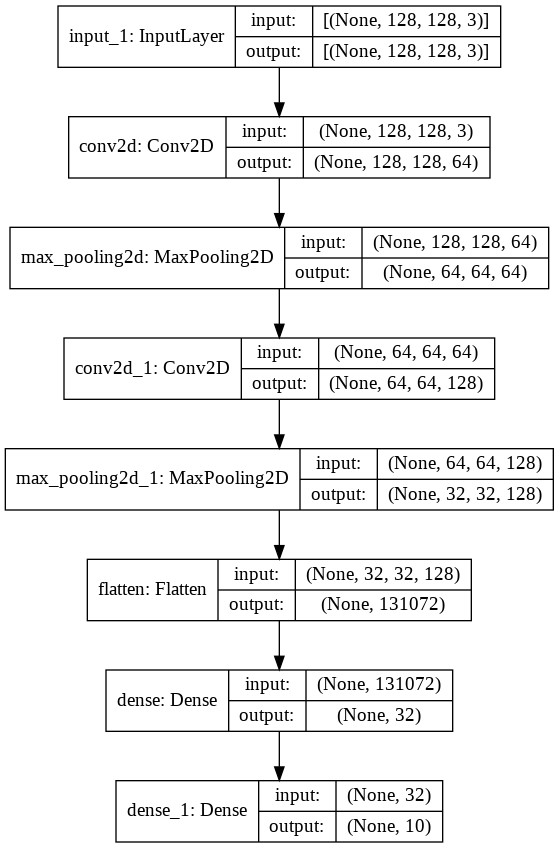

In [9]:
# モデルの初期化
model = Sequential()

# 入力層
model.add(InputLayer(input_shape=(128,128,3))) #今回は128x128ピクセルのカラー画像

# 中間層（１層目），畳み込み層
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))

# 中間層（2層目）プーリング層
model.add(MaxPooling2D(pool_size=(2, 2)))

# 中間層（3層目），畳み込み層
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))

# 中間層（4層目），プーリング層
model.add(MaxPooling2D(pool_size=(2, 2)))

# 中間層（5層目）, ここで二次元配列を一次元配列に変更
model.add(Flatten())

# ドロップアウト
# model.add(Dropout(rate=0.3))

# 中間層（6層目），全結合層
model.add(Dense(units=32, activation="relu"))

# ドロップアウト
# model.add(Dropout(rate=0.3))

# 出力層，全結合層
model.add(Dense(units=10, activation="softmax"))

# 構築したモデルを可視化して確認
plot_model(model, show_shapes=True)

構築したモデルは次の方法でも確認できます。この方法では，学習させるパラメータの数を確認することもできます。

In [10]:
# 構築したモデルを別の方法で可視化して確認
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 32)                4194336   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                3

### モデルのコンパイル

モデルを学習させるためにコンパイルします。指定する主なパラメータは以下の通りです。

* **loss** 損失関数。多クラス分類問題の場合は，"categorical_crossentropy"。
* **optimizer** 最適化関数。モデルを学習させるためのアルゴリズム。
* **metrics** 評価関数。パラメータの最適化には用いられない。

In [11]:
# モデルをコンパイルする
model.compile(
                loss="categorical_crossentropy", 
                optimizer="adam",
                metrics=["accuracy"]
            )

### モデルの学習（トレーニング）

モデルを学習させます。```model.fit()```だけでも学習できますが，```history=model.fit()```としておくことで後から学習経過を可視化できます。指定する主なパラメータは以下の通りです。

* **trainX** 学習用データの入力データ
* **trainY_onehot** 学習用データの出力データ
* **batch_size** 何個のデータごとにパラメータを更新するか？1バッチあたりのデータ数
* **epochs** すべての学習用データを何回通りみるか？
* **validation_data** 検証用データ。
* **shuffle** 学習用データを見る順番をシャッフルするか？
* **verbose** 学習経過の表示方法。0,1,2が選択可能。

In [12]:
history = model.fit(
                    trainX, trainY_onehot,
                    batch_size=64,
                    epochs=10,
                    validation_data=(validX, validY_onehot),
                    shuffle=True,
                    verbose=1
                   )

Epoch 1/10
157/157 [==============================] - 41s 53ms/step - loss: 2.1037 - accuracy: 0.2463 - val_loss: 1.6338 - val_accuracy: 0.4420
Epoch 2/10
157/157 [==============================] - 7s 48ms/step - loss: 1.4802 - accuracy: 0.5039 - val_loss: 1.4313 - val_accuracy: 0.4940
Epoch 3/10
157/157 [==============================] - 7s 48ms/step - loss: 1.0892 - accuracy: 0.6423 - val_loss: 1.4190 - val_accuracy: 0.5340
Epoch 4/10
157/157 [==============================] - 8s 48ms/step - loss: 0.7166 - accuracy: 0.7710 - val_loss: 1.4729 - val_accuracy: 0.5500
Epoch 5/10
157/157 [==============================] - 8s 48ms/step - loss: 0.4326 - accuracy: 0.8682 - val_loss: 1.7040 - val_accuracy: 0.5460
Epoch 6/10
157/157 [==============================] - 8s 48ms/step - loss: 0.2395 - accuracy: 0.9294 - val_loss: 1.9641 - val_accuracy: 0.5500
Epoch 7/10
157/157 [==============================] - 8s 49ms/step - loss: 0.1216 - accuracy: 0.9686 - val_loss: 2.3093 - val_accuracy: 0.560

### 学習経過の確認
学習経過を可視化して上手く学習できているか，過学習などが起こっていないかを確認しましょう。

Text(0, 0.5, 'Accuracy & Loss')

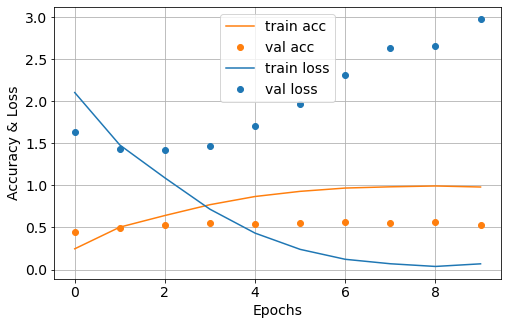

In [13]:
plt.figure(figsize=(8,5))
plt.rcParams["font.size"]=14

epoch = history.epoch
train_acc = history.history["accuracy"]
train_loss = history.history["loss"]
val_acc = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

plt.plot(epoch, train_acc, label="train acc", c="#ff7f0e")
plt.plot(epoch, val_acc, marker="o", lw=0, label="val acc", c="#ff7f0e")

plt.plot(epoch, train_loss, label="train loss", c="#1f77b4")
plt.plot(epoch, val_loss, marker="o", lw=0, label="val loss", c="#1f77b4")

#plt.ylim(0, 1)
#plt.xlim(0, 10)
plt.legend()
plt.grid()

plt.xlabel("Epochs")
plt.ylabel("Accuracy & Loss")

## 学習済みモデルの評価（検証用データを利用）
今回はテストデータの正解ラベル（正しいうどん屋名）が与えられていないので検証用データを使って学習済みモデルの精度を検証してみましょう。

### すべての検証用データに対してうどん店を推論

In [14]:
predY_valid_onehot = model.predict(validX)
predY_valid = np.argmax(predY_valid_onehot, axis=1)

### 推論結果の一部を可視化
学習済みモデルを使ってvalidXのデータから推論した結果の一部を表示してみましょう。

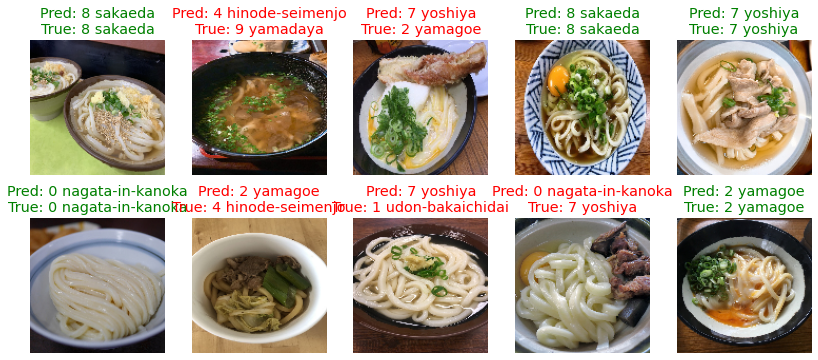

In [15]:
plt.figure(figsize=(14,6))
plt.rcParams["font.size"]=12

for i in range(10):
    plt.subplot(2, 5, i+1)
    img = validX[i]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")
    
    true_index = validY[i]
    pred_index = predY_valid[i]
   
    if true_index == pred_index:
        color = "green"
    else:
        color = "red"
    
    title = f"Pred: {pred_index} {udonya_list[pred_index]}\nTrue: {true_index} {udonya_list[true_index]}"
    plt.title(title, color=color)    # 推論結果をタイトルとして表示


### モデルの精度を検証
全ての検証用データに対するモデルの精度を統計的に検証します。

In [16]:
score = model.evaluate(validX, validY_onehot)
print(f"Validation Accuracy = {score[1]:.2f}")

16/16 [==============================] - 0s 11ms/step - loss: 2.9738 - accuracy: 0.5280
Validation Accuracy = 0.53


### 混同行列
モデルの精度をより詳しく検証するために混同行列を確認しましょう。

Text(0.5, 38.0, 'Prediction')

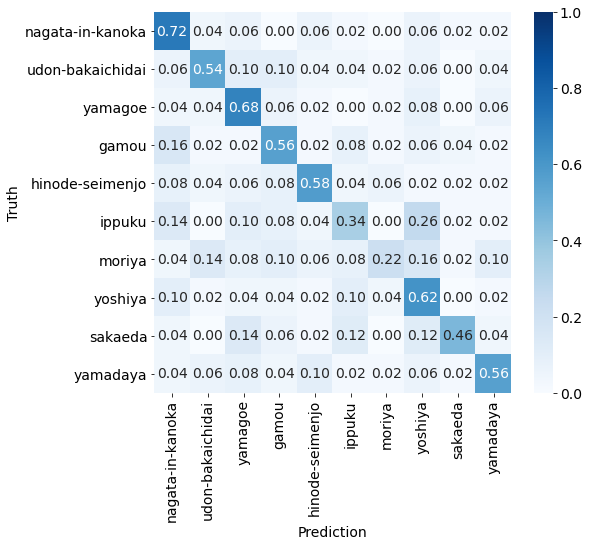

In [17]:
cmx = np.array(confusion_matrix(validY, predY_valid))    # 混同行列confusion matrixを作成

cmx_pct = np.zeros(cmx.shape)

for i in range(cmx.shape[0]):
    for j in range(cmx.shape[1]):
        cmx_pct[i, j] = cmx[i, j]/cmx[i, :].sum()

plt.rcParams["font.size"]=14
plt.figure(figsize=(8,7))
sns.heatmap(cmx_pct, annot=True, fmt=".2f", cmap="Blues", vmin=0, vmax=1,
            xticklabels=udonya_list, yticklabels=udonya_list)

plt.ylabel("Truth")
plt.xlabel("Prediction")

### 学習済みモデルの保存
次のセルを実行して学習済みのモデルを保存しておきましょう。

In [18]:
model_name = "UdonAI_model.h5"                       # model_nameを指定，拡張子は h5
model_path = os.path.join(working_dir, model_name)   # model_pathを作成
model.save(model_path)                               # 学習済みモデルを保存

## ハイパーパラメータの調整
深層学習モデルの学習において人間が決めることのできる条件をハイパーパラメータと呼びます。ハイパーパラメータを調整することでうどんAIの分類精度向上を目指しましょう。代表的なハイパーパラメータを以下に挙げます。


### モデル構築に関するハイパーパラメータ

* 層の種類と数
* Conv2D層のフィルタ数(filters)，カーネルサイズ(kernel_size), 活性化関数(activation)
* MaxPooling2D層のプーリングサイズ（pool_size）
* Dense層のユニット数(units), 活性化関数(activation)
* Dropout層のドロップアウト率(rate)



### モデルをコンパイルする際のハイパーパラメータ
* 最適化関数(optimizer)の種類と学習率

### モデル学習時のパラメータ
* エポック数(epochs)
* バッチサイズ(batch_size)
* シャッフルの有無

## コンペティション
うどんAIの分類精度を競い合ってみましょう。

### usernameの設定
```username```に自分の名前を記入してください。

**注意**
* 提出用ファイルとランキングのリストに反映されます。
* 半角英数字のみで記載してください。
* ハンドルネームでも構いません。他の人と同じにならないような名前を考えてください。
* 何回提出しても構いませんが，同じ```username```を使ってください。

In [19]:
username = "USERNAME"

### 提出ファイルの生成
以下のセルを実行して提出するファイルを生成してください。

In [20]:
# 推論結果（確率）が最大となる指標を求める
predY_test_onehot = model.predict(testX)
predY_test = np.argmax(predY_test_onehot, axis=1)

# pandasのDataFrameとして推論結果をまとめる
df = pd.DataFrame()
df["id"] = np.arange(len(predY_test))
df["label"]=predY_test

# 提出用ファイルを保存するパスを指定する
submission_filename = f"{username}_submission.xlsx"
submission_path = os.path.join(working_dir, submission_filename) 

# 提出用ファイルを保存する
df.to_excel(submission_path, index=False)

### 推論結果のアップロード
以下のGoogleフォームから```username_submission.xlsx```をアップロードしてください。

https://forms.gle/ByhichUApgjkERgM8

### ランキングの確認
現在のランキングはここで確認できます。

https://drive.google.com/file/d/1gxUgeX4JZGarOEli8LuuF1eCrgH8ZM2b/view?usp=sharing